Part 3: Evaluation & Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# since we have the model now, we now again load the dataset and especially test set, cos we want to test the model on test set,
# see its result
from torchvision.datasets import Flowers102
import torch

root = '/content/drive/MyDrive/flowers102/flowers102'
# Load only the test split
test_dataset = Flowers102(
    root=root,
    split='test',     # only load test images
    download=True
)

print(f"Number of test images: {len(test_dataset)}")



Number of test images: 6149


From here, its the same as previous notebook, but we just load test dataset

In [ ]:
from albumentations.pytorch import ToTensorV2
"""
Validation and test set no transfomrs, to keep it as original as it is.
"""

val_test_noaug = aug.Compose([
    aug.Resize(224, 224), #resize
    aug.Normalize(
        mean=(0.485, 0.456, 0.406),  #normalize, values are standard
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()# convert numpy array to tensor
])


In [ ]:
from torchvision.datasets import Flowers102
import albumentations as aug # we now load back the albumentations for test set from previous session
from torch.utils.data import Dataset, DataLoader
import numpy as np
# could be a better way to do it but i dont know

class Albumentations(Dataset):
    """
    Wrapper to apply Albumentations transforms to a torchvision dataset.
    """

    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)  # Convert PIL to NumPy
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label




In [ ]:
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader

data_root = '/content/drive/MyDrive/flowers102/flowers102'


# Load the test dataset properly

test = Flowers102(
    root=data_root,
    split='test',       # only load test split
    download=False      # already downloaded
)


# Apply Albumentations wrapper

test_data = Albumentations(test, val_test_noaug)



In [ ]:
# '''
# Load the dataset from drive
# Same from previous notebook eda

# '''

# save_dir = '/content/drive/MyDrive/flowers102/flowers102/flowers102'

# with torch.serialization.safe_globals([Flowers102]):
#     #train = torch.load(f'{save_dir}/train_dataset.pt', weights_only=False) # load each split
#     #val   = torch.load(f'{save_dir}/val_dataset.pt', weights_only=False) # weight_only = False , allows loading full python objects, like custom class Flowers102.
#     test  = torch.load(f'{save_dir}/test_dataset.pt', weights_only=False)
# # Weight_only = False
# # unpickling arbitrary code can run malicious code if file not trushworthy.
# # Required here because the .pt file contains a custom Dataset object, not just raw tensors.

# #train_data = Albumentations(train, train_augment)
# #val_data   = Albumentations(val, val_test_noaug)
# test_data  = Albumentations(test, val_test_noaug)



In [ ]:
from torch.utils.data import DataLoader

"""
Create PyTorch DataLoaders for training, validation, and testing.


train_loader = DataLoader(
    train_data,
    batch_size=16, # number of samples processed together before model update its parameters, 16 is good as too big will require more memory
    shuffle=True,        # order randomised
    num_workers=2  # numbers of parallel processes to load batches
)

val_loader = DataLoader(
    val_data,
    batch_size=16,
    shuffle=False,
    num_workers=2
)
"""

test_loader = DataLoader(
    test_data,
    batch_size=16,
    shuffle=False,
    num_workers=2
)


Until here, it ends. From below, we start to load model to evaluate

In [ ]:
import torch
import torch.nn as nn
from torchvision import models



# Load pre-trained model
# In this example, we use ResNet50 as the architecture.
# ResNet50 is what we used to train
model = models.resnet50(pretrained=False)

# Modify the final fully connected layer to match the number of classes in Flowers102
model.fc = nn.Linear(model.fc.in_features, 102)

# Load the trained weights from Google Drive

model.load_state_dict(torch.load('/content/drive/MyDrive/flowers102_resnet50_best.pt'))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
model.eval()

"""
Docstring: General of what we are doing

Purpose:
load a fine tuned model after we have trained on a pretrained model to evaluate on test set

Steps:
1. define the model architecture.
2. ensure output layer matches the class of flowers102 dataset.
3. load weights from drive
4. set model to eval to disable training-specific behavior.

Notes:
- ensure the model architecture matches exactly the one used during training.
- using `model.eval()` is critical for consistent evaluation metrics.
"""

'\nDocstring: General of what we are doing\n\nPurpose:\nload a fine tuned model after we have trained on a pretrained model to evaluate on test set\n\nSteps:\n1. define the model architecture.\n2. ensure output layer matches the class of flowers102 dataset.\n3. load weights from drive\n4. set model to eval to disable training-specific behavior.\n\nNotes:\n- ensure the model architecture matches exactly the one used during training.\n- using `model.eval()` is critical for consistent evaluation metrics.\n'

start evaluating result

In [ ]:
"""
Evaluation Script for Flowers102 Model
- Loads a saved test dataset (.pt file) and a trained model.
- Runs predictions on the test set.
- Computes metrics: Accuracy, Precision, Recall, F1-score (macro & weighted), Confusion Matrix.
- Optionally visualize misclassified images.
"""
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score # a library where we can check how well our model performed
from tqdm import tqdm
# -------------------------------
# Run evaluation
# -------------------------------
all_preds = []
all_labels = []

with torch.no_grad():  # no gradients needed for evaluation
    for images, labels in tqdm(test_loader, desc='evaluating'):
        #images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # get predicted class indices

        # Append predictions and labels individually
        for p, l in zip(preds.cpu().numpy(), labels.cpu().numpy()):
            all_preds.append(p)
            all_labels.append(l)


# Compute metrics
# accuracy is proportion of correctly predicted samples
accuracy = accuracy_score(all_labels, all_preds)
# f1_score: harmonic mean of precision and recall, useful when classes are imbalanced
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

# precision is fraction of predicted positives that are correct
precision_macro = precision_score(all_labels, all_preds, average='macro')
precision_weighted = precision_score(all_labels, all_preds, average='weighted')

# recall is fraction of actual positives that are correctly identified
recall_macro = recall_score(all_labels, all_preds, average='macro')
recall_weighted = recall_score(all_labels, all_preds, average='weighted')

# confusion Matrix is a table showing predicted vs true labels
cm = confusion_matrix(all_labels, all_preds)

# Print results
print(f"Test Accuracy: {accuracy:.4f}")# returns only 4 decimal points
print(f"F1-score (macro): {f1_macro:.4f}, F1-score (weighted): {f1_weighted:.4f}")
print(f"Precision (macro): {precision_macro:.4f}, Precision (weighted): {precision_weighted:.4f}")
print(f"Recall (macro): {recall_macro:.4f}, Recall (weighted): {recall_weighted:.4f}")
print("Confusion Matrix:")
print(cm)

evaluating: 100%|██████████| 385/385 [26:15<00:00,  4.09s/it]

Test Accuracy: 0.9027
F1-score (macro): 0.9039, F1-score (weighted): 0.9034
Precision (macro): 0.8971, Precision (weighted): 0.9182
Recall (macro): 0.9239, Recall (weighted): 0.9027
Confusion Matrix:
[[19  0  0 ...  0  0  0]
 [ 0 40  0 ...  0  0  0]
 [ 0  0 11 ...  0  0  0]
 ...
 [ 0  0  0 ... 28  0  0]
 [ 0  0  0 ...  0 37  0]
 [ 0  0  0 ...  0  0 28]]


for better visualization of confusion matrix, we will use seaborn and matplotlib to visualize

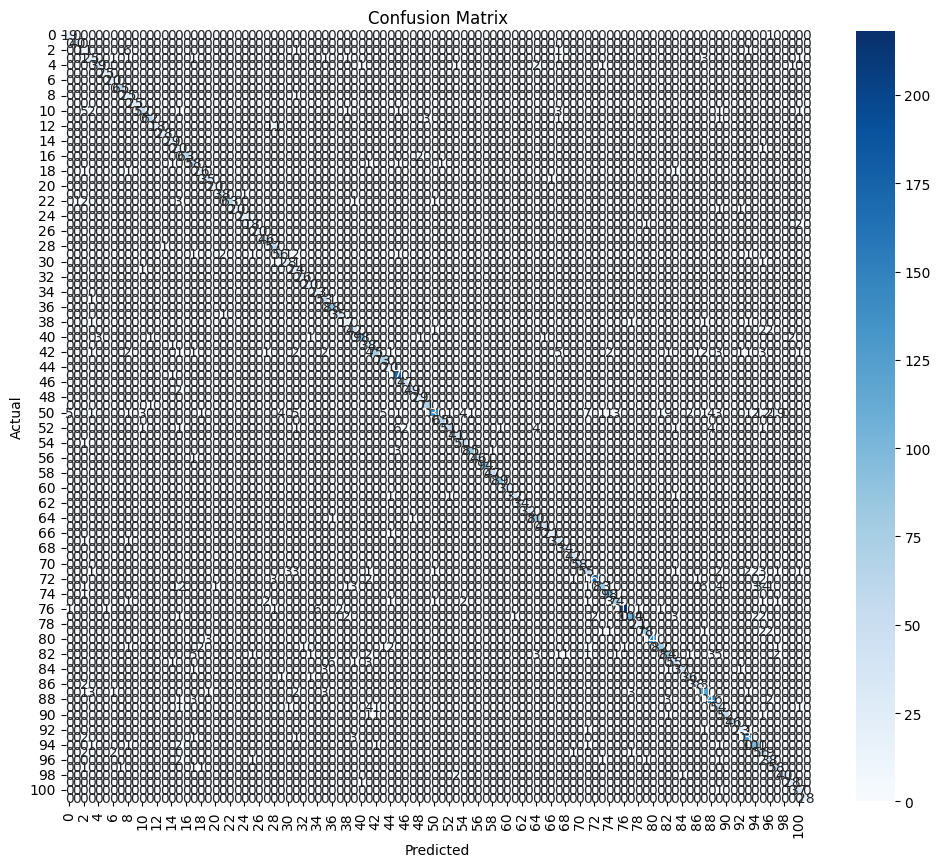

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns# both libraries for result visualization, for better understanding instead of looking at plain values

# Confusion matrix already computed: cm
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


From what we can see from the above confusion matrix, it did pretty well. There is a strong, obvious diagonal line from top left to bottom right, which means most predictions are accurate. very few misclassifications. Since the confusion matrix has too many classes, which results in above messy look. We try to normalize to see if we can spot any misclassifications and so on.

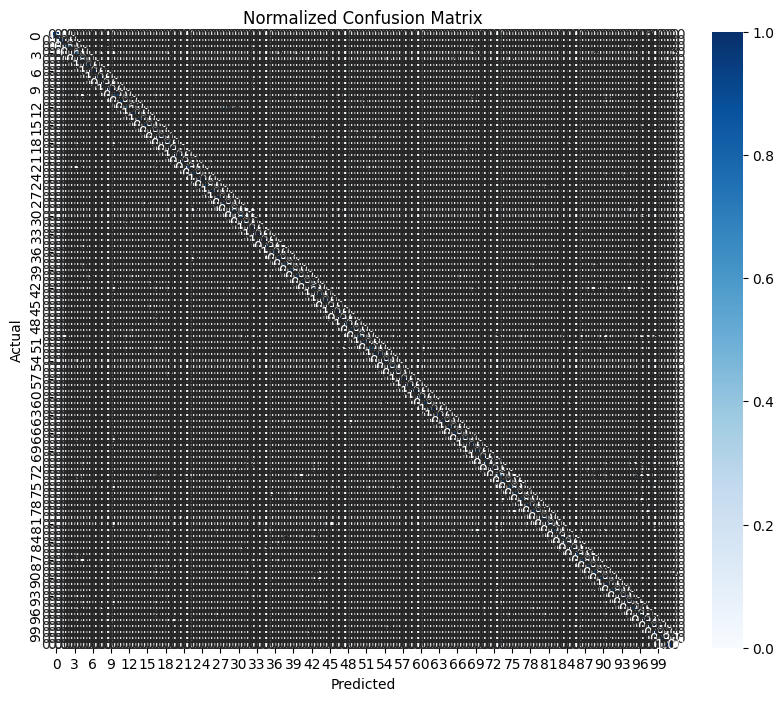

In [ ]:
norm_cm = confusion_matrix(all_labels, all_preds, normalize='true')

plt.figure(figsize=(10,8))
sns.heatmap(norm_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

since normmalized still looks messy, we try showing top confused class

In [ ]:
# show the top confused classes
cm = confusion_matrix(all_labels, all_preds)

# Zero out diagonal
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# Get top confusion pairs
top_confusions = np.dstack(np.unravel_index(
    np.argsort(cm_no_diag.ravel())[::-1][:10],
    cm_no_diag.shape
))[0]

top_confusions


array([[73, 95],
       [50, 97],
       [50, 95],
       [73, 15],
       [12, 28],
       [95, 96],
       [50, 82],
       [50, 71],
       [88, 89],
       [73, 87]])

from what we can see here these are the top most confused classes. On the left side we have true class,labels. Right side we have predicted class,labels. It could be said that for exp, class 73 often got predicted as class 95, class 50 got predicted as class 97 and so on.

In [ ]:
"""
    Evaluate the model on the test dataset and collect probabilities and labels.

    This loop performs the following:
    1. For each batch in the test_loader:
       - Computes the model outputs.
       - Converts outputs to probabilities using softmax.
       - Appends the batch probabilities and labels to lists.
    2. After all batches are processed, concatenates the lists into single tensors.

    Notes:
    - torch.no_grad() is used to disable gradient calculation, which reduces memory usage
      and speeds up evaluation.
    - We append entire batches instead of extending element-wise to improve efficiency.
    """

all_probs = []
all_labels = []

with torch.no_grad():


    for images, labels in test_loader:
        # Forward pass: get model outputs
        outputs = model(images)

        # Convert raw logits to probabilities (softmax along class dimension)
        probs = torch.softmax(outputs, dim=1)

        # Append the whole batch to lists
        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu()) # move to CPU

# After all batches, concatenate the list of tensors into single tensors
all_probs = torch.cat(all_probs, dim=0).numpy()  # shape: (num_samples, num_classes)
all_labels = torch.cat(all_labels, dim=0).numpy()


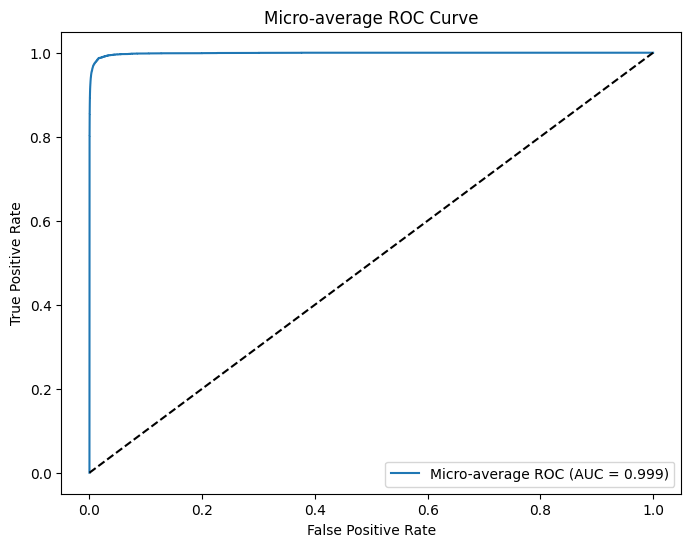

In [ ]:
"""
Compute and plot the micro-averaged ROC curve for a multi-class classification problem.

This approach summarizes the model's overall ability to distinguish between classes
by aggregating true positives and false positives across all classes.
It is especially suitable for problems with a large number of classes (e.g., 102),
where per-class ROC curves would be cluttered and hard to interpret.
"""

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Total classes
n_classes = 102

# Convert integer class labels into one-hot encoded format
# Shape: (num_samples, n_classes)
y_true = label_binarize(all_labels, classes=range(n_classes))

# Convert list of softmax probability vectors into NumPy array
# Shape: (num_samples, n_classes)
# Each row contains predicted probabilities for all 102 classes
y_score = np.array(all_probs)


# Micro-average ROC computation
# Flatten both arrays so that each (sample, class) pair
# is treated as a binary classification decision
fpr_micro, tpr_micro, _ = roc_curve(
    y_true.ravel(),
    y_score.ravel()
)

# Compute Area Under the Curve (AUC) for micro-average ROC
roc_micro = auc(fpr_micro, tpr_micro)


# ROC curve
plt.figure(figsize=(8, 6))

# micro-averaged ROC curve
plt.plot(
    fpr_micro,
    tpr_micro,
    label=f'Micro-average ROC (AUC = {roc_micro:.3f})'
)

# diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend()
plt.show()


from what you can see in the roc above, it is used to evaluate the model discriminative ability. as you can from all the classes, the 2 lines are clearly separated, which means correct and incorrect prediction are easily distinguished. higher conf score is also given to correct prediction, which means the model is doing well.

Error Analysis:

Like we see before, there are few misclassifications of classes. the reason behind it could be the flowers of that class has similar looking features which closely match the other classes, which will make the model confused. also, we have resized to 224 in training, in order to make all sizes equal, which will also makes the images loses some significant details, and it could be fatal for some flowers classes that by doing this it greatly reduces its unique identifier features. also the same class may look different due to lighting, angle etc. which make model confused.

Suggestion:

The first solution is instead of resize to smaller 224, we can train with larger input size, or the images size remain the same, so it wont lose its fine details. We could also do class aware approches for classes that look similar. we could do label smoothing, triplet loss, which will ensure model will learn more discriminative embeddings and correclty identified distinct features of different classes.

#Model Analysis

Given the dataset complexity, there are 102 types of different flowers. They may lookalike, or it is hard to tell certain flowers. Judging our training parameters, we have done what we could to make the model better, although we only trained 15 epochs. However, given the limited time and resources, the model was able to generalize well among flowers. For most of the classes, it has clearly identified its features and correctly classified it.

Analyze Trade Offs

The model we used is resnet50, which is accuracy, deployment feasibility and computational efficiency. From what we can see, the model accuracy was excellent, and also its inference time was good as well. Often times larger model will give better result, but the downside it they consume more memory and also inference time. the model we selected balances in the middle. Model size and accuracy intertwined, larger model size gives better fine detail identification but result in more computational cost while smaller model size is quick, low memory but less convincing detail captured performance.

Hyperparameter & Results

Few hyperparameters were used: Freeze layers, learning rate, batch size. By freezing layers, the model can stabilize training, improve fine detail feature learning. Batch size is how many data samples are processed before it updates its parameters, 16 was used here as it is in between very large batch, which uses more computational power, and very small batch, which the model has limited time to learn fine details before its parameters got updated. the learning we used was optimal, it is not too high, this will help in convergence stability. The option chosen gives us the balances of every world.